<a href="https://colab.research.google.com/github/GUNAPILLCO/neural_profit/blob/main/2_obtencion_preparacion_exploracion_datos/2_3_indicadores_tecnicos_close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2_3_Análisis de indicadores técnicos sobre close




## 0. Clonado de repositorio, importación de librerías y carga del dataset

### Clonado de repositorio e importación de librerías

In [1]:
#Clonamos el repo
#LINK DE REPOSITORIO: https://github.com/GUNAPILLCO/neural_profit

!git clone https://github.com/GUNAPILLCO/neural_profit.git

Cloning into 'neural_profit'...
remote: Enumerating objects: 216, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 216 (delta 83), reused 37 (delta 21), pack-reused 89 (from 1)
Receiving objects: 100% (216/216), 109.08 MiB | 23.13 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [2]:
import sys

#Instalación de librería pandas_market_calendars
#!{sys.executable} -m pip install -q pandas_market_calendars
#print("Librería instalada: pandas_market_calendars")

!{sys.executable} -m pip install -q ta
print("Librería instalada: technical-analysis")

# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import requests
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import ta
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
# Calendario de mercados
#import pandas_market_calendars as mcal

from ta.momentum import StochasticOscillator, ROCIndicator
from ta.volatility import BollingerBands, AverageTrueRange

from scipy.stats import spearmanr


  Preparing metadata (setup.py) ... done
Librería instalada: technical-analysis


### Carga del dataset mnq_intraday_data

In [3]:
def load_df():
    """
    Función para cargar un archivo Parquet desde el repositorio clonado
    """
    # Definir la URL del archivo Parquet en GitHub
    df_path = '/content/neural_profit/2_obtencion_preparacion_exploracion_datos/mnq_intraday_data.parquet'

    # Leer el archivo Parquet y cargarlo en un DataFrame
    df = pd.read_parquet(df_path)

    # Asegurar que el índice esté en formato datetime
    df.index = pd.to_datetime(df.index)

    # Crear una nueva columna 'date' con la fecha extraída del índice
    df['date'] = df.index.date

    # Reordenar columnas: 'date', 'time_str', y luego el resto
    cols = ['date'] + [col for col in df.columns if col not in ['date']]

    df = df[cols]

    return df

In [4]:
mnq_intraday = load_df()

## 1. Definición de Target

Se utiliza el retorno futuro a 30 minutos (target_return_30) como variable objetivo del modelo porque, tras evaluar múltiples hipótesis de predicción, fue el horizonte temporal con mayor IC medio para los indicadores técnicos seleccionados.

Por lo tanto, usaremos los indicadores técnicos para analizar el comportamiento de dicha variable objetivo.



In [5]:
def add_targets (df):
  df['target_return_30'] = df.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))
  return df

In [6]:
mnq_intraday = add_targets(mnq_intraday)

In [7]:
mnq_intraday

,date,open,high,low,close,volume,target_return_30
datetime,,,,,,,
2019-12-23 08:00:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8733.75,31,0.000372
2019-12-23 08:01:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8734.00,16,0.000286
2019-12-23 08:02:00-05:00,2019-12-23,8734.00,8734.00,8733.25,8733.25,23,0.000315
2019-12-23 08:03:00-05:00,2019-12-23,8734.25,8734.50,8734.00,8734.00,23,0.000315
2019-12-23 08:04:00-05:00,2019-12-23,8734.00,8734.00,8733.50,8733.75,12,0.000458
...,...,...,...,...,...,...,...
2025-06-13 15:56:00-04:00,2025-06-13,21624.50,21635.00,21613.50,21617.50,3251,NaN
2025-06-13 15:57:00-04:00,2025-06-13,21616.50,21635.25,21615.75,21623.75,2201,NaN
2025-06-13 15:58:00-04:00,2025-06-13,21623.25,21632.75,21616.50,21621.75,1859,NaN


## 2. Indicadores Técnicos

Los indicadores técnicos calculados en cada jornada tienen como objetivo capturar dinámicas intradía relevantes del precio y el volumen, tales como momentum, sobrecompra/sobreventa, presión institucional o posibles reversiones. Cada uno aporta información complementaria sobre el comportamiento del mercado a corto plazo. En particular:

### 2.1. **RSI (Relative Strength Index)**

Mide la fuerza relativa del precio en los últimos períodos (3, 5, 7, 14), oscilando entre 0 y 100.

  - Valores altos indican posibles condiciones de sobrecompra, mientras que valores bajos sugieren sobreventa.
  
  - Calculado sobre los precios de cierre intradía, el RSI es útil para identificar puntos de reversión potenciales en el corto plazo.

In [8]:
def calcular_rsi(df=mnq_intraday, target='close' ):
  rsi_columns = ['rsi_14', 'rsi_7', 'rsi_5', 'rsi_3']

  def aplicar_por_dia (grupo):
        grupo = grupo.copy()
        grupo['rsi_14'] = ta.momentum.RSIIndicator(grupo[target], window=14).rsi()
        grupo['rsi_7'] = ta.momentum.RSIIndicator(grupo[target], window=7).rsi()
        grupo['rsi_5'] = ta.momentum.RSIIndicator(grupo[target], window=5).rsi()
        grupo['rsi_3'] = ta.momentum.RSIIndicator(grupo[target], window=3).rsi()
        return grupo

  df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)
  return df, rsi_columns

### 2.2. **Momentum**

Mide la aceleración reciente del precio mediante la variación porcentual entre el precio actual y el de hace N minutos.

  - Un valor positivo indica una subida reciente, lo que podría sugerir una continuación alcista.

  - Un valor negativo señala presión bajista reciente, potencialmente anticipando una continuación a la baja.

In [9]:
def calcular_momentum(df=mnq_intraday, target='close' ):
  momentum_columns = ['momentum_10', 'momentum_5','momentum_3']

  def aplicar_por_dia (grupo):
        grupo = grupo.copy()
        grupo['momentum_10'] = grupo[target].pct_change(10)
        grupo['momentum_5'] = grupo[target].pct_change(5)
        grupo['momentum_3'] = grupo[target].pct_change(3)
        return grupo

  df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)
  return df, momentum_columns

### 2.3. **Relación de volumen actual vs. su promedio reciente**

Compara el volumen actual con su media móvil en distintas ventanas de tiempo: 15, 20 y 30 minutos.

  - Un valor mayor a 1 indica un volumen superior al promedio de la ventana correspondiente, lo que puede reflejar interés creciente o actividad institucional.

  - Un valor menor a 1 sugiere baja actividad o consolidación del precio.

Esta métrica permite detectar aumentos de volumen ("spikes") sin depender del volumen en crudo, y las diferentes ventanas permiten capturar variaciones en la dinámica de corto plazo con distinta sensibilidad.


In [10]:
def calcular_volumen_ratio(df=mnq_intraday, target='close'):
  volume_ratio_columns = ['volume_ratio_15', 'volume_ratio_20', 'volume_ratio_30']

  def aplicar_por_dia (grupo):
        grupo = grupo.copy()
        grupo['volume_ratio_15'] = grupo['volume'] / grupo['volume'].rolling(15).mean()
        grupo['volume_ratio_20'] = grupo['volume'] / grupo['volume'].rolling(20).mean()
        grupo['volume_ratio_30'] = grupo['volume'] / grupo['volume'].rolling(30).mean()
        return grupo

  df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

  return df, volume_ratio_columns

### 2.4. **MACD diferencial (señal de cruce)**

Representa la diferencia entre la línea MACD y su línea de señal (una media exponencial de sí misma).

  - Un valor positivo y creciente indica momentum alcista.

  - Un valor negativo sugiere presión bajista.
  
Es ampliamente utilizado para detectar giros de tendencia y cambios en la dinámica del mercado.


In [11]:
def calcular_macd(df=mnq_intraday, target='close'):
    macd_columns = ['macd']

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()
        grupo['macd'] = ta.trend.MACD(grupo[target]).macd_diff()
        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, macd_columns

### 2.5. **Distancia del precio actual a su EMA (15, 20 y 30 minutos)**

Mide el desvío porcentual del precio respecto a su media exponencial en diferentes ventanas, y actúa como indicador de sobreextensión o retorno a la media.

  - Si el precio está muy por encima de la EMA, puede anticipar una reversión bajista o una posible aceleración alcista.

  - Si está por debajo, podría indicar agotamiento o presión vendedora.<br>

Esta métrica se expresa como un porcentaje relativo, lo que facilita la comparación entre distintas ventanas temporales y condiciones de mercado.

Usar varias ventanas (15, 20 y 30 minutos) permite capturar diferentes horizontes de reacción del precio frente a su media móvil.


In [12]:
def calcular_ema(df=mnq_intraday, target='close'):
    ema_columns = ['price_ema15', 'price_ema20', 'price_ema30']

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()
        grupo['price_ema15'] = grupo[target] / grupo[target].ewm(span=15).mean() - 1
        grupo['price_ema20'] = grupo[target] / grupo[target].ewm(span=20).mean() - 1
        grupo['price_ema30'] = grupo[target] / grupo[target].ewm(span=30).mean() - 1
        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, ema_columns

### 2.6. **%K Estocástico**

Mide la posición relativa del precio actual dentro del rango alto-bajo de los últimos n periodos (generalmente 14).

  - Se utiliza para identificar condiciones extremas de sobrecompra o sobreventa.

  - Un valor cercano a 100 indica que el precio está cerca del máximo reciente (potencial sobrecompra), mientras que un valor cercano a 0 indica proximidad al mínimo reciente (posible sobreventa).

Es útil para detectar momentos en los que el precio puede estar excesivamente extendido y susceptible a una reversión.


In [13]:
def calcular_stochastic(df=mnq_intraday, target='close'):
    stoch_columns = ['stoch_k_14', 'stoch_k_20', 'stoch_k_30']

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()

        stoch_14 = StochasticOscillator(
            high=grupo['high'], low=grupo['low'], close=grupo[target], window=14, smooth_window=3
        )
        grupo['stoch_k_14'] = stoch_14.stoch()

        stoch_20 = StochasticOscillator(
            high=grupo['high'], low=grupo['low'], close=grupo[target], window=20, smooth_window=3
        )
        grupo['stoch_k_20'] = stoch_20.stoch()

        stoch_30 = StochasticOscillator(
            high=grupo['high'], low=grupo['low'], close=grupo[target], window=30, smooth_window=3
        )
        grupo['stoch_k_30'] = stoch_30.stoch()

        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, stoch_columns


### 2.7.**%B de Bollinger (Bollinger Band Percent)**

Indica la posición del precio actual en relación con las bandas de Bollinger, que están construidas alrededor de una media móvil usando desviaciones estándar.

  - Un valor de %B > 1 sugiere que el precio está por encima de la banda superior, lo que podría implicar exceso de optimismo o momentum fuerte.

  - Un valor < 0 indica que está por debajo de la banda inferior, posible señal de pánico o sobreventa extrema.

Este indicador es eficaz para identificar zonas de congestión, breakout o reversiones basadas en la volatilidad reciente.


In [14]:
from ta.volatility import BollingerBands

def calcular_bollinger(df=mnq_intraday, target='close'):
    bollinger_columns = [
        'bb_percent_15_15', 'bb_percent_20_15', 'bb_percent_30_15',
        'bb_percent_15_20', 'bb_percent_20_20', 'bb_percent_30_20',
        'bb_percent_15_25', 'bb_percent_20_25', 'bb_percent_30_25',
    ]

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()

        # std: 1.5
        grupo['bb_percent_15_15'] = BollingerBands(grupo[target], window=15, window_dev=1.5).bollinger_pband()
        grupo['bb_percent_20_15'] = BollingerBands(grupo[target], window=20, window_dev=1.5).bollinger_pband()
        grupo['bb_percent_30_15'] = BollingerBands(grupo[target], window=30, window_dev=1.5).bollinger_pband()

        # std: 2
        grupo['bb_percent_15_20'] = BollingerBands(grupo[target], window=15, window_dev=2).bollinger_pband()
        grupo['bb_percent_20_20'] = BollingerBands(grupo[target], window=20, window_dev=2).bollinger_pband()
        grupo['bb_percent_30_20'] = BollingerBands(grupo[target], window=30, window_dev=2).bollinger_pband()

        # std: 2.5
        grupo['bb_percent_15_25'] = BollingerBands(grupo[target], window=15, window_dev=2.5).bollinger_pband()
        grupo['bb_percent_20_25'] = BollingerBands(grupo[target], window=20, window_dev=2.5).bollinger_pband()
        grupo['bb_percent_30_25'] = BollingerBands(grupo[target], window=30, window_dev=2.5).bollinger_pband()

        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, bollinger_columns


### 2.8. **ATR normalizado (Average True Range / precio)**

Representa la volatilidad absoluta reciente ajustada al nivel del precio.

  - El ATR mide el rango promedio de oscilación de un activo en los últimos n periodos, capturando tanto movimientos bruscos como gaps.

  - Al normalizarlo dividiéndolo por el precio, se obtiene una medida relativa, comparable entre distintos niveles de mercado.

Este indicador es útil para detectar momentos de alta o baja volatilidad intradía, que pueden influir en la confiabilidad de otras señales técnicas.


In [15]:
def calcular_atr(df=mnq_intraday, target='close'):
    atr_columns = ['atr_norm']

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()
        atr = AverageTrueRange(high=grupo['high'], low=grupo['low'], close=grupo[target], window=14)
        grupo['atr'] = atr.average_true_range()
        grupo['atr_norm'] = grupo['atr'] / grupo[target]
        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, atr_columns


### 2.9. **ROC (Rate of Change)**

Calcula la tasa de cambio porcentual del precio con respecto a su valor n minutos atrás.

- Es un indicador de momentum que capta aceleraciones o desaceleraciones recientes del precio.

- Valores positivos indican presión alcista; negativos, presión bajista.

A diferencia del momentum tradicional, el ROC expresa el cambio de forma normalizada y en porcentaje, lo que facilita su interpretación comparativa entre distintos activos o marcos temporales.


In [33]:
def calcular_roc(df=mnq_intraday, target='close'):
    roc_columns = ['roc_5', 'roc_10', 'roc_20']

    def aplicar_por_dia(grupo):
        grupo = grupo.copy()
        grupo['roc_5'] = ROCIndicator(close=grupo[target], window=5).roc()
        grupo['roc_10'] = ROCIndicator(close=grupo[target], window=10).roc()
        grupo['roc_20'] = ROCIndicator(close=grupo[target], window=20).roc()
        return grupo

    df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)

    return df, roc_columns

##3. Calculo de Information Coefficient (IC)

El Information Coefficient (IC) es la correlación de Spearman entre el factor y el retorno futuro. Mide si el ranking del factor predice el ranking del retorno.

- IC > 0: el factor tiene relación positiva → valores altos del factor tienden a preceder retornos positivos.

- IC < 0: relación inversa → valores altos del factor tienden a preceder retornos negativos (reversión).

- IC ≈ 0: el factor es probablemente ruido o no tiene señal útil.

Valores comunes en finanzas:

- Entre 0.05 a 0.1: débil pero útil.

- Mayor a 0.1: muy raro, pero fuerte.

- Menor 0.05 o cercano a 0: probablemente ruido.

### **Función para calcular IC:**

In [17]:
def calcular_IC(df: pd.DataFrame, target: str, factors: list[str]):
    grouped = df.groupby('date')

    print(f"IC promedio por factor (diario) sobre el {target}:\n")

    resultados = []

    for factor in factors:
        daily_ics = []

        for date, group in grouped:
            df_valid = group[[factor, target]].dropna()
            if len(df_valid) >= 20:
                ic = spearmanr(df_valid[factor], df_valid[target]).correlation
                if np.isfinite(ic):
                    daily_ics.append(ic)

        if daily_ics:
            mean_ic = np.mean(daily_ics)
            std_ic = np.std(daily_ics)
            dias_validos = len(daily_ics)
            print(f"{factor:15}: IC medio = {mean_ic:.4f} | std = {std_ic:.4f} | días válidos = {dias_validos}")
            resultados.append({
                'factor': factor,
                'ic_mean': mean_ic,
                'ic_std': std_ic,
                'dias_validos': dias_validos
            })
        else:
            print(f"{factor:15}: sin días válidos para cálculo")

    return pd.DataFrame(resultados)

### 3.1. **RSI (Relative Strength Index)**

In [18]:
mnq_rsi, rsi_cols = calcular_rsi()
IC_rsi = calcular_IC(mnq_rsi, 'target_return_30', rsi_cols)

IC promedio por factor (diario) sobre el target_return_30:

rsi_14         : IC medio = -0.0882 | std = 0.1722 | días válidos = 1311
rsi_7          : IC medio = -0.0629 | std = 0.1379 | días válidos = 1311
rsi_5          : IC medio = -0.0539 | std = 0.1202 | días válidos = 1311
rsi_3          : IC medio = -0.0432 | std = 0.0954 | días válidos = 1311


#### 3.1.1. Conclusiones

| Indicador | IC medio | Desv. Estándar | Comentario                  |
|-----------|----------|----------------|-----------------------------|
| `rsi_14`  | -0.0882  | 0.1722         | Señal más fuerte y estable. |
| `rsi_7`   | -0.0629  | 0.1379         | Señal moderada.             |
| `rsi_5`   | -0.0539  | 0.1202         | Señal débil.                |
| `rsi_3`   | -0.0432  | 0.0954         | Menor poder predictivo.     |

<br>

- El IC promedio disminuye al acortar la ventana del RSI, lo que indica que las señales más estables (como `rsi_14`) tienen mejor capacidad para anticipar el target_return_30.

- Aunque todos los IC son negativos, esto es coherente con una hipótesis de reversión a la media: RSI alto suele anticipar retornos negativos, y viceversa.

- `rsi_14` destaca como el más informativo, con el mayor valor absoluto de IC medio y la desviación estándar más alta, aunque aceptable.

- Las versiones con ventana más corta (`rsi_3`, `rsi_5`, `rsi_7`) aportan menos y podrían ser redundantes

#### 3.1.2. Recomendaciones

- Priorizar `rsi_14` como variable principal basada en RSI para el modelo de predicción a 30 minutos.

- Considerar `rsi_7` como complemento, si se aplica selección automática de variables.

- No incluir todos los RSI al mismo tiempo en modelos sensibles a multicolinealidad. Aplicar regularización o técnicas de reducción si se desea incluir múltiples versiones.

### 3.2. **Momentum**

In [32]:
mnq_momentum, momentum_cols = calcular_momentum()
IC_momentum = calcular_IC(mnq_momentum, 'target_return_30', momentum_cols)

IC promedio por factor (diario) sobre el target_return_30:

momentum_10    : IC medio = -0.0532 | std = 0.1297 | días válidos = 1311
momentum_5     : IC medio = -0.0402 | std = 0.0940 | días válidos = 1311
momentum_3     : IC medio = -0.0329 | std = 0.0734 | días válidos = 1311


#### 3.2.1. Conclusiones

| Indicador     | IC medio | Desv. Estándar | Comentario                  |
|---------------|----------|----------------|-----------------------------|
| `momentum_10` | -0.0532  | 0.1297         | Señal moderada y más estable. |
| `momentum_5`  | -0.0402  | 0.0940         | Señal débil.                |
| `momentum_3`  | -0.0329  | 0.0734         | Menor poder predictivo.     |

<br>

- Los indicadores de momentum muestran un IC negativo decreciente al acortarse la ventana, lo cual es consistente con una hipótesis de reversión a la media intradía.

- `momentum_10` presenta el mejor desempeño relativo, aunque su IC medio sigue siendo bajo en términos absolutos.

- Las versiones más cortas (`momentum_3` y `momentum_5`) muestran menor estabilidad y menor potencia predictiva.

- Ningún indicador de momentum destaca por sí solo como una fuente fuerte de señal predictiva, pero podrían aportar valor marginal en combinación con otros factores.




#### 3.2.2. Recomendaciones

- Priorizar `momentum_10` como la versión más informativa de este grupo, si se desea incluir un factor de momentum clásico.

- Evitar el uso simultáneo de `momentum_3`, `momentum_5` y `momentum_10`, ya que son altamente colineales.

- Considerar combinar `momentum_10` con factores de reversión como RSI o bandas de Bollinger para enriquecer la señal.

- Evaluar su importancia real dentro de un modelo ML usando técnicas de selección o importancia de características.

### 3.3. **Relación de volumen actual vs. su promedio reciente**

In [20]:
mnq_volumen, volumen_cols = calcular_volumen_ratio()
IC_volumen = calcular_IC(mnq_volumen, 'target_return_30', volumen_cols)

IC promedio por factor (diario) sobre el target_return_30:

volume_ratio_15: IC medio = 0.0053 | std = 0.0643 | días válidos = 1311
volume_ratio_20: IC medio = 0.0048 | std = 0.0785 | días válidos = 1311
volume_ratio_30: IC medio = 0.0051 | std = 0.1039 | días válidos = 1311


#### 3.3.1. Conclusiones

| Indicador        | IC medio | Desv. Estándar | Comentario                       |
|------------------|----------|----------------|----------------------------------|
| `volume_ratio_15`| 0.0053   | 0.0643         | Sin señal clara, muy cercano a cero. |
| `volume_ratio_20`| 0.0048   | 0.0785         | Sin poder predictivo aparente.     |
| `volume_ratio_30`| 0.0051   | 0.1039         | Ligeramente más volátil, sin señal útil. |

<br>

- Todos los indicadores muestran un IC cercano a cero, lo que indica que no tienen una correlación significativa con el retorno futuro a 30 minutos.

- La señal positiva es demasiado débil para ser útil, y no mejora al aumentar la ventana.

- A pesar de su bajo IC, el volumen podría ser relevante en interacciones no lineales o contextos particulares, pero no aporta valor individualmente.

#### 3.3.2. Recomendaciones

- No incluir `volume_ratio_*` como factores individuales en el modelo, ya que no muestran señal predictiva significativa.

- Considerar rediseñar la métrica de volumen para capturar anomalías extremas o comportamientos inusuales, por ejemplo, usando z-score de volumen o cambios abruptos.

- Si se desea usar volumen como input, explorar su uso en combinación con otros factores (por ejemplo, momentum + volumen alto).

- Aplicar selección automática de variables si se incluyen múltiples métricas derivadas del volumen para evitar sobreajuste o redundancia.

### 3.4. **MACD diferencial (señal de cruce)**

In [21]:
mnq_macd, macd_cols = calcular_macd()
IC_macd = calcular_IC(mnq_macd, 'target_return_30', macd_cols)

IC promedio por factor (diario) sobre el target_return_30:

macd           : IC medio = -0.0180 | std = 0.1352 | días válidos = 1311


#### 3.4.1. Conclusiones

| Indicador | IC medio | Desv. Estándar | Comentario                          |
|-----------|----------|----------------|-------------------------------------|
| `macd`    | -0.0180  | 0.1352         | Señal muy débil e inestable.        |

<br>

- El indicador MACD muestra un IC medio muy cercano a cero, lo que sugiere falta de capacidad predictiva lineal sobre el `target_return_30`.

- Su desviación estándar es relativamente alta para un IC tan bajo, lo cual indica inestabilidad y posible ruido.

- A pesar de su popularidad como indicador de tendencia, en este horizonte intradía de 30 minutos, MACD no parece aportar señal útil de forma individual.


#### 3.4.2. Recomendaciones

- No priorizar `macd` como variable explicativa principal, dado su bajo poder predictivo observado.

- Si se incluye en un modelo de machine learning, debe ser evaluado en combinación con otros factores y dentro de un pipeline de selección automática de variables.

- Puede considerarse su exclusión para reducir dimensionalidad, salvo que pruebas empíricas en modelos no lineales muestren alguna utilidad oculta.

- Si se desea usar MACD, podría explorarse su cruce con la línea de señal o su pendiente, en lugar del valor absoluto.

### 3.5. **Distancia del precio actual a su EMA (15, 20 y 30 minutos)**

In [22]:
mnq_ema, ema_cols = calcular_ema()
IC_ema = calcular_IC(mnq_ema, 'target_return_30', ema_cols)

IC promedio por factor (diario) sobre el target_return_30:

price_ema15    : IC medio = -0.0636 | std = 0.1449 | días válidos = 1311
price_ema20    : IC medio = -0.0723 | std = 0.1590 | días válidos = 1311
price_ema30    : IC medio = -0.0873 | std = 0.1766 | días válidos = 1311


#### 3.5.1. Conclusiones

| Indicador     | IC medio | Desv. Estándar | Comentario                              |
|---------------|----------|----------------|-----------------------------------------|
| `price_ema15` | -0.0636  | 0.1449         | Señal moderada y algo volátil.          |
| `price_ema20` | -0.0723  | 0.1590         | Mejora leve en potencia, con más ruido. |
| `price_ema30` | -0.0873  | 0.1766         | Mayor señal, aunque más inestable.      |

<br>

- Todas las EMAs muestran IC negativo, lo que sugiere que un precio por encima de su media exponencial podría anticipar una reversión bajista a 30 minutos (y viceversa).

- A mayor longitud de la ventana (de 15 a 30), el IC medio tiende a mejorar ligeramente, aunque también aumenta la variabilidad diaria.

- `price_ema30` presenta el mejor desempeño de la serie, con un IC moderadamente útil para un factor individual, aunque no especialmente fuerte.


#### 3.5.2. Recomendaciones

- Considerar incluir `price_ema30` como referencia de tendencia o desbalance de precio respecto a su media suavizada.

- Evitar incluir múltiples EMAs simultáneamente, ya que capturan señales muy similares y pueden generar colinealidad.

- Usar la EMA como parte de un sistema de reversión a la media o como base para otros factores derivados (por ejemplo, desviación del precio respecto a EMA).

- Si se trabaja con modelos sensibles a ruido, aplicar regularización o técnicas de selección de variables para validar su aporte real.

### 3.6. **%K Estocástico**

In [23]:
mnq_stoch, stoch_cols = calcular_stochastic()
IC_stoch = calcular_IC(mnq_stoch, 'target_return_30', stoch_cols)

IC promedio por factor (diario) sobre el target_return_30:

stoch_k_14     : IC medio = -0.0590 | std = 0.1266 | días válidos = 1311
stoch_k_20     : IC medio = -0.0702 | std = 0.1472 | días válidos = 1311
stoch_k_30     : IC medio = -0.0870 | std = 0.1704 | días válidos = 1311


#### 3.6.1. Conclusiones

| Indicador     | IC medio | Desv. Estándar | Comentario                              |
|---------------|----------|----------------|-----------------------------------------|
| `stoch_k_14`  | -0.0590  | 0.1266         | Señal moderada, relativamente estable.  |
| `stoch_k_20`  | -0.0702  | 0.1472         | Mejor señal, pero más volátil.          |
| `stoch_k_30`  | -0.0870  | 0.1704         | Mayor poder predictivo individual.      |

<br>

- El `stoch_k` muestra una señal consistentemente negativa, lo cual es coherente con un enfoque de reversión a la media: lecturas altas del oscilador anticipan caídas y viceversa.

- Al igual que con EMAs y RSI, las ventanas más largas capturan mejor la tendencia general, lo que se refleja en un IC más alto en `stoch_k_30`.

- La relación entre longitud de ventana y estabilidad se mantiene: mayor ventana → mayor señal pero también mayor variabilidad diaria.

#### 3.6.2. Recomendaciones

- Utilizar `stoch_k_30` como representación del estado de sobrecompra o sobreventa con mejor potencia predictiva dentro de esta familia.

- Evitar incluir múltiples `stoch_k_*` al mismo tiempo, ya que son altamente redundantes.

- Este indicador puede complementar a RSI en modelos que exploran reversión a la media, siempre validando su contribución marginal.

- Explorar su uso como bandera binaria (`stoch_k` > 80, `stoch_k` < 20) para capturar zonas extremas si se desea mejorar interpretabilidad o evitar ruido.

### 3.7.**%B de Bollinger (Bollinger Band Percent)**


In [24]:
mnq_bollinger, bollinger_cols = calcular_bollinger()
IC_bollinger = calcular_IC(mnq_bollinger, 'target_return_30', bollinger_cols)

IC promedio por factor (diario) sobre el target_return_30:

bb_percent_15_15: IC medio = -0.0556 | std = 0.1245 | días válidos = 1311
bb_percent_20_15: IC medio = -0.0635 | std = 0.1410 | días válidos = 1311
bb_percent_30_15: IC medio = -0.0783 | std = 0.1650 | días válidos = 1311
bb_percent_15_20: IC medio = -0.0556 | std = 0.1245 | días válidos = 1311
bb_percent_20_20: IC medio = -0.0635 | std = 0.1410 | días válidos = 1311
bb_percent_30_20: IC medio = -0.0783 | std = 0.1650 | días válidos = 1311
bb_percent_15_25: IC medio = -0.0556 | std = 0.1245 | días válidos = 1311
bb_percent_20_25: IC medio = -0.0635 | std = 0.1410 | días válidos = 1311
bb_percent_30_25: IC medio = -0.0783 | std = 0.1650 | días válidos = 1311


#### 3.7.1. Conclusiones

| Indicador           | IC medio | Desv. Estándar | Comentario                              |
|---------------------|----------|----------------|-----------------------------------------|
| `bb_percent_15_15`  | -0.0556  | 0.1245         | Señal débil pero consistente.           |
| `bb_percent_20_15`  | -0.0635  | 0.1410         | Ligeramente mejor, algo más volátil.    |
| `bb_percent_30_15`  | -0.0783  | 0.1650         | Mejor señal entre las variantes con std=15. |
| `bb_percent_15_20`  | -0.0556  | 0.1245         | Idéntico a `bb_percent_15_15`.          |
| `bb_percent_20_20`  | -0.0635  | 0.1410         | Idéntico a `bb_percent_20_15`.          |
| `bb_percent_30_20`  | -0.0783  | 0.1650         | Idéntico a `bb_percent_30_15`.          |
| `bb_percent_15_25`  | -0.0556  | 0.1245         | Idéntico a `bb_percent_15_15`.          |
| `bb_percent_20_25`  | -0.0635  | 0.1410         | Idéntico a `bb_percent_20_15`.          |
| `bb_percent_30_25`  | -0.0783  | 0.1650         | Idéntico a `bb_percent_30_15`.          |

<br>

- Las métricas son repetidas por combinación de parámetros, pero en realidad sólo hay tres resultados distintos según el parámetro de periodo (30, 20, 15) del cálculo de la media.

- La señal negativa y moderada sugiere que los precios extremos dentro de las bandas se asocian con reversiones posteriores, consistente con la hipótesis de reversión a la media.

- `bb_percent_30_*` presenta el mayor IC (en valor absoluto), aunque también la mayor desviación estándar, lo que indica mejor potencia pero más inestabilidad diaria.


#### 3.7.2. Recomendaciones

- Priorizar `bb_percent_30_20` o `bb_percent_30_25` como representantes más informativos de esta familia.

- Evitar incluir todas las variantes, ya que sus valores son redundantes.

- Estos factores pueden ser útiles para identificar zonas de sobreextensión de precios, especialmente en modelos que integren reversión, volatilidad o detección de extremos.

- Si se usa junto a RSI o Stochastic, validar si la señal aporta información adicional o si es redundante en la práctica.

### 3.8. **ATR normalizado (Average True Range / precio)**

In [25]:
mnq_atr, atr_cols = calcular_atr()
IC_atr = calcular_IC(mnq_atr, 'target_return_30', atr_cols)

IC promedio por factor (diario) sobre el target_return_30:

atr_norm       : IC medio = 0.0899 | std = 0.2389 | días válidos = 1311


#### 3.8.1. Conclusiones

| Indicador   | IC medio | Desv. Estándar | Comentario                                      |
|-------------|----------|----------------|-------------------------------------------------|
| `atr_norm`  | 0.0899   | 0.2389         | Señal positiva moderadamente fuerte pero inestable. |

<br>

- Este indicador muestra el IC medio más alto entre todos los factores evaluados hasta ahora, aunque con una desviación estándar también considerable.

- La señal positiva sugiere que cuando la volatilidad reciente (medida por ATR) es alta, es más probable que se produzcan movimientos positivos en los siguientes 30 minutos.

- Alternativamente, podría estar capturando un efecto de momentum impulsado por alta volatilidad, donde el mercado continúa en la dirección actual después de expansión de rango.




#### 3.8.2. Recomendaciones

- Incluir `atr_norm` como una de las variables principales del modelo, dada su potencia predictiva individual.

- Monitorear su estabilidad, ya que su alta desviación estándar indica que no es consistente todos los días, y podría funcionar mejor en ciertos contextos (por ejemplo, horarios o condiciones de mercado específicas).

- Considerar cruzarlo con otros factores como RSI o price action para aumentar robustez, especialmente en modelos no lineales que puedan capturar estas interacciones.

- Evitar interpretarlo como dirección del movimiento; más bien, **sugiere que algo significativo podría pasar, sin especificar si será positivo o negativo**— útil para modelos que predicen magnitud además de dirección.

### 3.9. **ROC (Rate of Change)**

In [34]:
mnq_roc, roc_cols = calcular_roc()
IC_roc = calcular_IC(mnq_roc, 'target_return_30', roc_cols)

IC promedio por factor (diario) sobre el target_return_30:

roc_5          : IC medio = -0.0402 | std = 0.0940 | días válidos = 1311
roc_10         : IC medio = -0.0532 | std = 0.1297 | días válidos = 1311
roc_20         : IC medio = -0.0724 | std = 0.1720 | días válidos = 1311


#### 3.9.1. Conclusiones

| Indicador | IC medio | Desv. Estándar | Comentario                              |
|-----------|----------|----------------|-----------------------------------------|
| `roc_5`   | -0.0402  | 0.0940         | Señal débil, pero bastante estable.     |
| `roc_10`  | -0.0532  | 0.1297         | Mejor señal que `roc_5`, algo más volátil. |
| `roc_20`  | -0.0724  | 0.1720         | Mayor poder predictivo, pero más inestable.

<br>

- Los indicadores `roc_*` muestran una relación negativa progresiva con `target_return_30`, lo que es consistente con una hipótesis de reversión a la media: cuanto mayor el retorno reciente, mayor la probabilidad de un retroceso.

- Al aumentar la ventana (de 5 a 20), mejora el IC medio pero también aumenta la desviación estándar, reflejando mayor señal pero menos estabilidad.

- `roc_20` presenta el mejor desempeño dentro de esta familia, aunque con mayor variabilidad diaria.

#### 3.9.2. Recomendaciones

- Priorizar `roc_20` si se desea incorporar un factor tipo rate of change, por su mayor potencia predictiva relativa.

- Evitar incluir simultáneamente `roc_5`, `roc_10` y `roc_20`, debido a su colinealidad; elegir una sola versión.

- `roc_20` puede complementar factores como `price_ema30` o `rsi_14` para reforzar señales de reversión, especialmente en modelos que exploren contexto de sobrecompra o sobreventa.

- Evaluar su interacción con otros factores en modelos no lineales para aprovechar su potencial de forma más robusta.


### 3.10. Análisis en conjunto

Observemos todos los IC correspondiente a cada indicador técnico:

In [35]:
IC_indicadores = pd.concat([IC_rsi, IC_momentum, IC_volumen, IC_macd, IC_ema, IC_stoch, IC_bollinger, IC_atr, IC_roc], axis=0)

In [36]:
IC_indicadores

,factor,ic_mean,ic_std,dias_validos
0,rsi_14,-0.088180,0.172203,1311
1,rsi_7,-0.062888,0.137946,1311
2,rsi_5,-0.053870,0.120162,1311
3,rsi_3,-0.043152,0.095357,1311
0,momentum_10,-0.053240,0.129744,1311
1,momentum_5,-0.040213,0.093976,1311
2,momentum_3,-0.032888,0.073411,1311
0,volume_ratio_15,0.005303,0.064345,1311
1,volume_ratio_20,0.004812,0.078493,1311
2,volume_ratio_30,0.005131,0.103872,1311


## 4. Selección de mejores indicadores técnicos

### 4.1. Criterio: IC Score

Nuestro enfoque para la selección de los mejores indicadores técnicos es el **IC Score**

El IC score combina dos métricas clave para evaluar la calidad de un indicador técnicos:

- |IC medio|: mide el poder predictivo promedio del indicador (cuánto se asocia su valor con el retorno futuro).

- IC std: mide la volatilidad o inestabilidad del indicador a lo largo del tiempo (días en tu caso).

El cociente `|IC| / std` representa un signal-to-noise ratio: cuánta señal útil aporta el factor, ajustada por su variabilidad diaria.

Esto permite seleccionar indicadores que no solo tienen buen rendimiento promedio, sino que además son consistentes. En otras palabras, es una forma de medir la **relación señal/ruido** de cada indicador.

**Ventajas del IC Score como criterio de selección**

| Criterio | Descripción |
| --- | --- |
| **Objetividad** | Es una métrica cuantitativa clara, sin intervención manual ni subjetiva. |
| **Consistencia** | Premia indicadores que funcionan bien _y_ consistentemente a lo largo de días. |
| **Robustez estadística** | Penaliza indicadores que parecen buenos pero son muy inestables (overfitting). |
| **Comparabilidad** | Permite ordenar decenas de indicadores heterogéneos en una sola escala. |
| **Modelado automatizado** | Compatible con pipelines de selección automática, sin intervención humana. |


**¿Por qué es mejor que usar solo el IC medio?**

Porque un factor puede tener un IC alto pero extremadamente volátil, lo cual indica que su utilidad es espuria o inconstante. En cambio, un factor con IC moderado pero muy estable suele ser más confiable para modelos reales.

En el trading cuantitativo institucional, es común que los equipos usen IC Score o variantes del Information Ratio (IR) como filtro previo antes de usar un factor en producción.

Ejemplo concreto:

- `atr_norm`: tiene el IC medio más alto (+0.0899), pero su std también es muy alta (0.2389) → bajo IC score ≈ 0.38

- `rsi_14`: IC medio menor (-0.0882), pero más estable (std = 0.17) → mejor IC score ≈ 0.51

Entonces, si tenés que elegir entre ellos para un modelo robusto, el IC score sugiere que `rsi_14` es más confiable, aunque su IC medio sea menor.

**Conclusión**

El IC score es una métrica más equilibrada, porque considera tanto la fuerza como la confiabilidad del factor.

Usarlo como criterio principal te protege de elegir factores ruidosos, y mejora la calidad de las señales que entrarán a tu modelo, especialmente si:

- Estás evaluando muchos indicadores (como en tu caso).

- Vas a usar modelos complejos que son sensibles al ruido (como redes neuronales).

- Querés automatizar y escalar tu proceso de feature selection.

### 4.2. Calculo de IC Score

In [48]:
# Calcular la nueva columna IC_score
IC_indicadores["IC_score"] = IC_indicadores["ic_mean"].abs() / IC_indicadores["ic_std"]

# Eliminar la columna 'dias_validos'
IC_indicadores = IC_indicadores.drop(columns=["dias_validos"])

# Ordenar por IC_score de mayor a menor
IC_indicadores = IC_indicadores.sort_values(by="IC_score", ascending=False).reset_index(drop=True)

KeyError: "['dias_validos'] not found in axis"

In [49]:
IC_indicadores

,factor,ic_mean,ic_std,IC_score
0,rsi_14,-0.088180,0.172203,0.512072
1,stoch_k_30,-0.087019,0.170373,0.510757
2,price_ema30,-0.087274,0.176637,0.494089
3,stoch_k_20,-0.070241,0.147213,0.477135
4,bb_percent_30_20,-0.078302,0.165005,0.474544
5,bb_percent_30_15,-0.078302,0.165005,0.474544
6,bb_percent_30_25,-0.078302,0.165005,0.474544
7,stoch_k_14,-0.059042,0.126565,0.466500
8,rsi_7,-0.062888,0.137946,0.455891
9,price_ema20,-0.072318,0.158994,0.454850


### 4.3. Correlación entre indicadores técnicos

Ya ordenamos los indicadores por IC Score, que es un métrica robusta de señal ajustada por estabilidad. Pero necesitamos controlar la redundancia (multicolinealidad). Ya que indicadores con alta correlación podrían aportar información duplicada, y:

- Distorsionar modelos lineales
- Inflar varianzas en los coeficientes
- Hacer innecesariamente complejo el modelo

**¿Cómo lo controlo?**
<br>
Usaré una matriz de correlación entre indicadores, típicamente sobre sus valores normalizados (z-score por día) para detectar grupos redundantes.


In [56]:
# Paso 1: definir la lista de dataframes
dataframes = [mnq_rsi, mnq_momentum, mnq_volumen, mnq_macd, mnq_ema,
              mnq_stoch, mnq_bollinger, mnq_atr, mnq_roc]

# Paso 2: extraer columnas técnicas (excluyendo duplicadas)
dataframes_tecnicos = []
for df in dataframes:
    columnas_tecnicas = df.drop(columns=["date", "open", "high", "low", "close", "volume", "target_return_30"])
    dataframes_tecnicos.append(columnas_tecnicas)

# Paso 3: tomar base (por ejemplo, el primero) con columnas comunes
df_base = mnq_rsi[["date", "open", "high", "low", "close", "volume", "target_return_30"]].copy()

# Paso 4: concatenar todo
mnq_completo = pd.concat([df_base] + dataframes_tecnicos, axis=1)

In [57]:
 mnq_completo

,date,open,high,low,close,volume,target_return_30,rsi_14,rsi_7,rsi_5,...,bb_percent_20_20,bb_percent_30_20,bb_percent_15_25,bb_percent_20_25,bb_percent_30_25,atr,atr_norm,roc_5,roc_10,roc_20
datetime,,,,,,,,,,,,,,,,,,,,,
2019-12-23 08:00:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8733.75,31,0.000372,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
2019-12-23 08:01:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8734.00,16,0.000286,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
2019-12-23 08:02:00-05:00,2019-12-23,8734.00,8734.00,8733.25,8733.25,23,0.000315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
2019-12-23 08:03:00-05:00,2019-12-23,8734.25,8734.50,8734.00,8734.00,23,0.000315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
2019-12-23 08:04:00-05:00,2019-12-23,8734.00,8734.00,8733.50,8733.75,12,0.000458,NaN,NaN,49.931413,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-13 15:56:00-04:00,2025-06-13,21624.50,21635.00,21613.50,21617.50,3251,NaN,42.096236,39.066557,37.152379,...,0.221020,0.206181,0.305903,0.276816,0.264945,18.829924,0.000871,-0.094741,0.027763,-0.073959
2025-06-13 15:57:00-04:00,2025-06-13,21616.50,21635.25,21615.75,21623.75,2201,NaN,45.107585,45.637235,47.055931,...,0.325051,0.306572,0.428328,0.360041,0.345258,18.877787,0.000873,-0.047379,0.024285,-0.156988
2025-06-13 15:58:00-04:00,2025-06-13,21623.25,21632.75,21616.50,21621.75,1859,NaN,44.313396,43.871077,44.265764,...,0.316411,0.280376,0.406692,0.353128,0.324301,18.690088,0.000864,-0.003469,0.010407,-0.219205


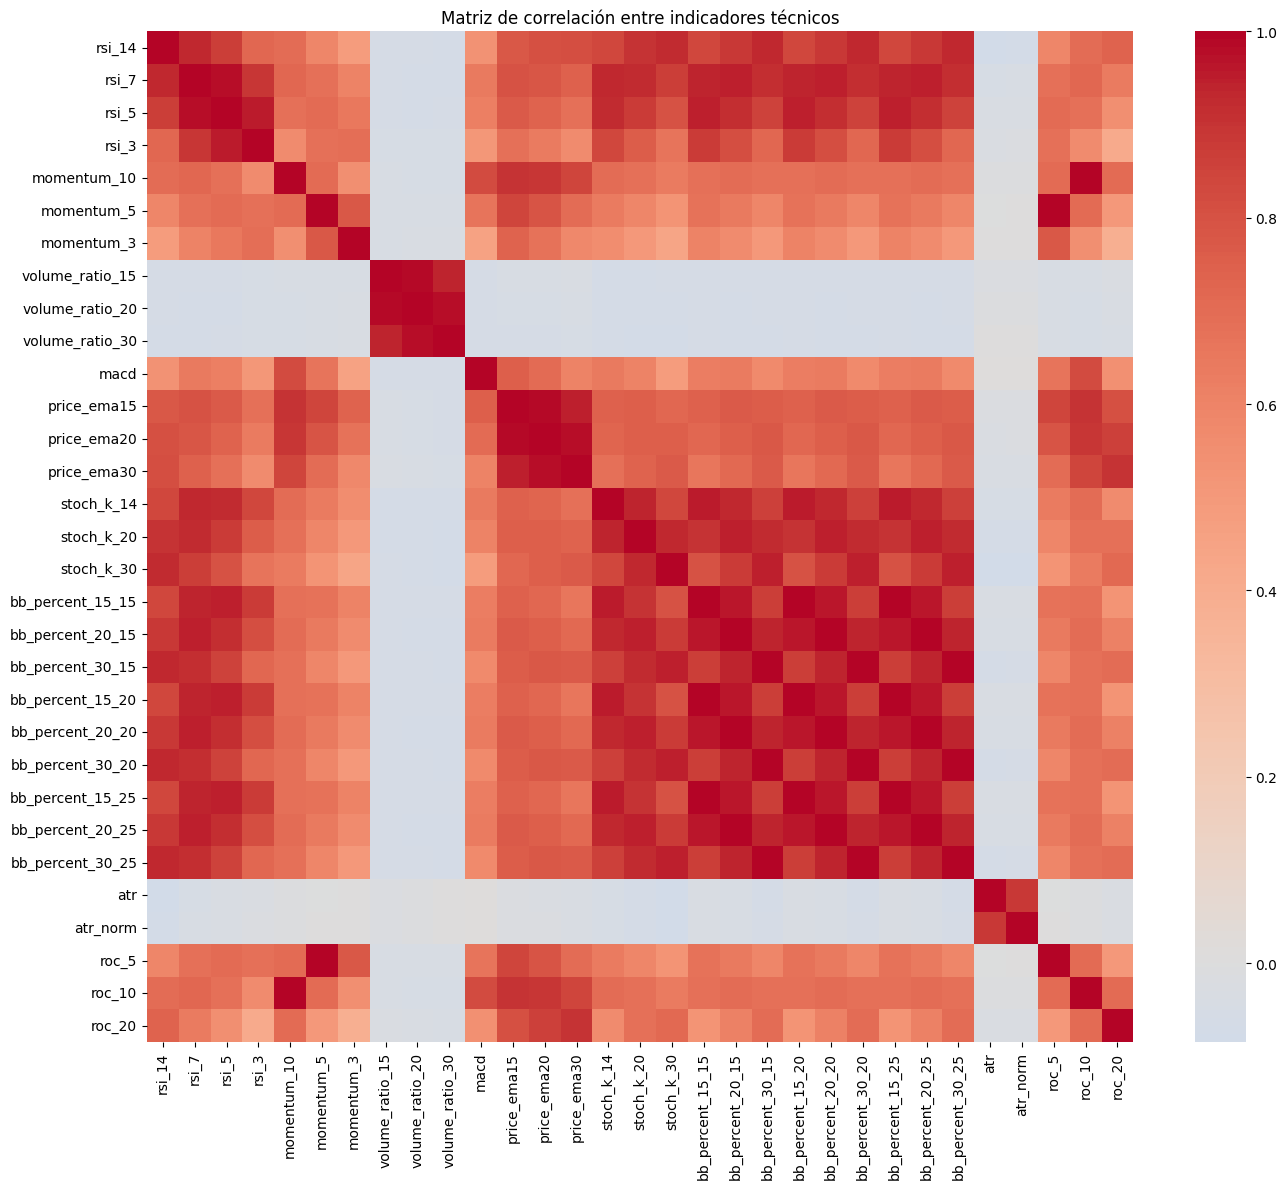

In [58]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Columnas base que NO queremos incluir en la matriz de correlación
columnas_base = ["date", "open", "high", "low", "close", "volume", "target_return_30"]

# Extraer solo los indicadores técnicos
indicadores = mnq_completo.drop(columns=columnas_base, errors='ignore')

# Calcular la matriz de correlación
matriz_corr = indicadores.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(14, 12))
sns.heatmap(matriz_corr, cmap="coolwarm", center=0, annot=False, fmt=".2f")
plt.title("Matriz de correlación entre indicadores técnicos")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [59]:
# Suponiendo que ya tenés los siguientes:
# - IC_indicadores: DataFrame con columna 'factor'
# - mnq_completo: DataFrame con todos los indicadores técnicos

# Paso 1: excluir columnas no técnicas
columnas_base = ["date", "open", "high", "low", "close", "volume", "target_return_30"]
df_tecnicos = mnq_completo.drop(columns=columnas_base, errors='ignore')

# Paso 2: calcular la matriz de correlación
matriz_corr = df_tecnicos.corr()

# Paso 3: para cada factor en IC_indicadores, encontrar el más correlacionado
mas_correlacionado = []
valor_correlacion = []

for factor in IC_indicadores["factor"]:
    if factor in matriz_corr.columns:
        corrs = matriz_corr[factor].drop(labels=[factor])  # eliminar autocorrelación
        max_corr_factor = corrs.abs().idxmax()  # nombre del más correlacionado
        max_corr_value = matriz_corr.loc[factor, max_corr_factor]  # valor de la correlación
    else:
        max_corr_factor = None
        max_corr_value = None

    mas_correlacionado.append(max_corr_factor)
    valor_correlacion.append(max_corr_value)

# Paso 4: añadir al DataFrame original
IC_indicadores["mas_correlacionado"] = mas_correlacionado
IC_indicadores["valor_correlacion"] = valor_correlacion

In [60]:
IC_indicadores

,factor,ic_mean,ic_std,IC_score,mas_correlacionado,valor_correlacion
0,rsi_14,-0.088180,0.172203,0.512072,rsi_7,0.936097
1,stoch_k_30,-0.087019,0.170373,0.510757,bb_percent_30_25,0.946797
2,price_ema30,-0.087274,0.176637,0.494089,price_ema20,0.980876
3,stoch_k_20,-0.070241,0.147213,0.477135,bb_percent_20_15,0.948167
4,bb_percent_30_20,-0.078302,0.165005,0.474544,bb_percent_30_15,1.000000
5,bb_percent_30_15,-0.078302,0.165005,0.474544,bb_percent_30_20,1.000000
6,bb_percent_30_25,-0.078302,0.165005,0.474544,bb_percent_30_15,1.000000
7,stoch_k_14,-0.059042,0.126565,0.466500,bb_percent_15_25,0.952644
8,rsi_7,-0.062888,0.137946,0.455891,rsi_5,0.983023
9,price_ema20,-0.072318,0.158994,0.454850,price_ema15,0.990143


Para elegir los mejores indicadores técnicos como variables de entrada para un modelo de ML predictivo, vamos a evaluar 3 aspectos clave:
<br><br>
1. IC medio (ic_mean): mide poder predictivo promedio
  - Cuanto más alto (en valor absoluto), mejor.
  - Un valor negativo no es malo si es consistente (ej.: reversión a la media).
<br><br>
2. Estabilidad (ic_std): menor es mejor
  - Si un factor tiene un buen IC pero muy variable día a día, es menos confiable.
  - Ideal: alto IC medio y baja desviación estándar.
<br><br>
3. Interpretabilidad y complementariedad
  - ¿Captura algo diferente al resto?
  - ¿Es redundante o aporta nueva información?


Las recomendaciones finales de indicadores técnicos son:

**RSI:**

- **`rsi_14` debe ser priorizado** como alpha factor principal, dado que obtuvo el IC medio más alto entre todos los indicadores evaluados, con excelente estabilidad.
- **`rsi_7` puede considerarse como alternativa secundaria**, aportando una señal más reactiva, pero aún robusta y consistente.

**MACD:**

- **`macd` puede incluirse como factor complementario**, especialmente si el modelo incorpora señales de momentum o detección de cambios de tendencia.
- Su poder predictivo es más limitado comparado con otros factores, por lo que **conviene validar su utilidad dentro de un conjunto multivariado**, evaluando su contribución marginal al desempeño general del modelo.

**Bollinger Bands (%B):**

- **`bb_percent_30_20` es la variante más recomendable**, ya que muestra el mayor IC medio con buena estabilidad.
- **`bb_percent_20_20` también es una alternativa sólida**, con buen desempeño y menor ventana, lo que puede ser útil si se buscan señales más rápidas.
- No es necesario conservar todas las combinaciones; basta con **incluir una o dos versiones representativas** (idealmente con `window=30` y/o `window=20`), ya que las demás no aportan valor adicional.
- Este grupo debe considerarse como **una fuente clave de señales predictivas**.

**ATR:**

- **`atr_norm` se destaca como uno de los mejores alpha factors**, combinando un IC alto con estabilidad razonable.
- Su capacidad para capturar volatilidad relativa al precio lo convierte en un complemento valioso para otros factores basados en tendencia o momentum.

### 4.1. Función para agregar mejores indicadores técnicos

---



In [ ]:
def best_indicators(df=mnq_intraday, target='target_return_30' ):
  best_indicators_list = ['rsi_14', 'rsi_7', 'macd', 'bb_percent_20_20', 'bb_percent_30_20', 'atr_norm']

  def aplicar_por_dia (grupo):
        grupo = grupo.copy()
        #RSI 14 y RSI 7
        grupo['rsi_14'] = ta.momentum.RSIIndicator(grupo[target], window=14).rsi()
        grupo['rsi_7'] = ta.momentum.RSIIndicator(grupo[target], window=7).rsi()

        #MACD
        grupo['macd'] = ta.trend.MACD(grupo[target]).macd_diff()

        #BB PERCENT
        grupo['bb_percent_20_20'] = BollingerBands(grupo[target], window=20, window_dev=2).bollinger_pband()
        grupo['bb_percent_30_20'] = BollingerBands(grupo[target], window=30, window_dev=2).bollinger_pband()

        #ATR Normalizado
        atr = AverageTrueRange(high=grupo['high'], low=grupo['low'], close=grupo[target], window=14)
        grupo['atr'] = atr.average_true_range()
        grupo['atr_norm'] = grupo['atr'] / grupo[target]
        #atr = AverageTrueRange(high=grupo['high'], low=grupo['low'], close=grupo[target], window=14)
        #grupo['atr_norm'] = atr.average_true_range() / grupo[target]

        return grupo

  df = df.groupby('date', group_keys=False).apply(aplicar_por_dia)
  return df, best_indicators_list

In [ ]:
mnq_intraday, best_indicators_list = best_indicators()

In [ ]:
IC_ba = calcular_IC(mnq_intraday, 'target_return_30', best_indicators_list)

IC promedio por factor (diario) sobre el target_return_30:

rsi_14         : IC medio = 0.6387 | std = 0.0666 | días válidos = 1311
rsi_7          : IC medio = 0.4740 | std = 0.0582 | días válidos = 1311
macd           : IC medio = 0.1962 | std = 0.0984 | días válidos = 1311
bb_percent_20_20: IC medio = 0.4619 | std = 0.0670 | días válidos = 1311
bb_percent_30_20: IC medio = 0.5679 | std = 0.0757 | días válidos = 1311
atr_norm       : IC medio = 0.4313 | std = 0.1131 | días válidos = 1311


In [ ]:
mnq_intraday

,date,open,high,low,close,volume,target_return_30,rsi_14,rsi_7,macd,bb_percent_30_20,atr_norm,bb_percent_20_20,atr
datetime,,,,,,,,,,,,,,
2019-12-23 08:00:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8733.75,31,0.000372,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
2019-12-23 08:01:00-05:00,2019-12-23,8734.00,8734.25,8733.75,8734.00,16,0.000286,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
2019-12-23 08:02:00-05:00,2019-12-23,8734.00,8734.00,8733.25,8733.25,23,0.000315,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
2019-12-23 08:03:00-05:00,2019-12-23,8734.25,8734.50,8734.00,8734.00,23,0.000315,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
2019-12-23 08:04:00-05:00,2019-12-23,8734.00,8734.00,8733.50,8733.75,12,0.000458,NaN,NaN,NaN,NaN,0.0,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-13 15:56:00-04:00,2025-06-13,21624.50,21635.00,21613.50,21617.50,3251,NaN,63.154131,77.443346,8.095646e-07,NaN,NaN,NaN,3412.904825
2025-06-13 15:57:00-04:00,2025-06-13,21616.50,21635.25,21615.75,21623.75,2201,NaN,63.154131,77.443346,6.476516e-07,NaN,NaN,NaN,3170.518766
2025-06-13 15:58:00-04:00,2025-06-13,21623.25,21632.75,21616.50,21621.75,1859,NaN,63.154131,77.443346,5.181213e-07,NaN,NaN,NaN,2945.213855


In [40]:
best_indicators_list

NameError: name 'best_indicators_list' is not defined

In [41]:
best_indicators_list = [
    'rsi_14',
    'stoch_k_30',
    'price_ema30',
    'stoch_k_20',
    'bb_percent_30_15',
    'price_ema20',
    'bb_percent_30_20',
    'roc_20',
    'bb_percent_20_15',
    'price_ema15'
]

## 5. Análisis del IC durante el día.

### 5.1. Funciones

#### Función para plotear el comportamiento

In [42]:
def plot_ic_tecnicos_por_minuto(df: pd.DataFrame,
                                 factors: list[str],
                                 target: str,
                                 date_col: str = 'date'):
    """
    Calcula y grafica el IC por minuto intradía para una lista de indicadores técnicos.
    El eje X muestra el tiempo intradía (desde las 08:00 AM).
    """

    df = df.copy()
    df['minute_index'] = df.groupby(date_col).cumcount()

    def compute_ic_series(factor_col, target_col):
        grouped = df[[factor_col, target_col, 'minute_index']].dropna()
        return grouped.groupby('minute_index').apply(
            lambda x: x[factor_col].corr(x[target_col])
        )

    # Calcular IC por minuto para cada factor
    ic_series = {factor: compute_ic_series(factor, target) for factor in factors}

    # Eje X: minutos del día y etiquetas horarias
    xticks = np.arange(0, 451, 30)
    start_time = pd.to_datetime("08:00")
    time_labels = [(start_time + pd.Timedelta(minutes=i)).strftime("%H:%M") for i in xticks]

    # Graficar
    plt.figure(figsize=(15, 6))
    for factor, ic in ic_series.items():
        plt.plot(ic.index, ic, label=factor)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f'IC por minuto del día - Target: {target}')
    plt.xlabel('Hora intradía')
    plt.ylabel('Information Coefficient (IC)')
    plt.xticks(ticks=xticks, labels=time_labels, rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ic_series

#### Función para analizar los mejores y peores IC durante el día

In [38]:
def analyze_intraday_ic_extremes(ic_minute_df: pd.DataFrame,
                                 mode: str = 'worst',
                                 top_n: int = 30,
                                 market_open: str = "08:00") -> pd.DataFrame:
    """
    Analiza series de IC minuto a minuto para distintos alpha factors.
    Retorna el IC mínimo, IC máximo, y el promedio de los top_n peores o mejores ICs,
    indicando la hora exacta en la que ocurren los extremos.

    Parámetros:
    - ic_minute_df: DataFrame con columnas = alpha factors, índice = minuto (0 a 450)
    - mode: 'worst' para los peores ICs, 'best' para los mejores ICs
    - top_n: cantidad de valores extremos a promediar
    - market_open: hora de inicio del mercado en formato "HH:MM" (por defecto 08:30)

    Retorna:
    - DataFrame resumen ordenado por el promedio de los ICs extremos
    """
    results = []
    base_time = pd.to_datetime(market_open)

    for col in ic_minute_df.columns:
        series = ic_minute_df[col].dropna()

        if mode == 'worst':
            extreme_vals = series.nsmallest(top_n)
        elif mode == 'best':
            extreme_vals = series.nlargest(top_n)
        else:
            raise ValueError("El parámetro 'mode' debe ser 'worst' o 'best'.")

        extreme_mean = extreme_vals.mean()

        # IC mínimo y su hora
        min_ic = series.min()
        min_minute = series.idxmin()
        min_time = (base_time + pd.Timedelta(minutes=min_minute)).strftime("%H:%M")

        # IC máximo y su hora
        max_ic = series.max()
        max_minute = series.idxmax()
        max_time = (base_time + pd.Timedelta(minutes=max_minute)).strftime("%H:%M")

        results.append({
            'Alpha Factor': col,
            'IC mínimo': min_ic,
            'Hora del IC mínimo': min_time,
            'IC máximo': max_ic,
            'Hora del IC máximo': max_time,
            f'Promedio de los {top_n} {"peores" if mode == "worst" else "mejores"} ICs': extreme_mean
        })

    result_df = pd.DataFrame(results).set_index('Alpha Factor')
    sort_col = result_df.columns[-1]
    result_df = result_df.sort_values(sort_col, ascending=(mode == 'worst'))

    return result_df

### 5.2. Gráfico de comportamiento

In [43]:
# 1. Calcular el IC por minuto para los mejores factores
ic_por_minuto = plot_ic_tecnicos_por_minuto(mnq_intraday, best_indicators_list, target='target_return_30')

KeyError: "['rsi_14'] not in index"

Este gráfico muestra la evolución intradía del Information Coefficient (IC) minuto a minuto para los principales indicadores técnicos seleccionados.

`rsi_14`
- Se mantiene como el mejor factor durante todo el día.
- Alcanza su pico entre las 09:00 y 09:30, superando un IC de 0.8.
- Conserva valores superiores a 0.5 durante toda la jornada, mostrando alta estabilidad y poder predictivo constante.

`rsi_7`
- Fuerte tras la apertura, con un IC que supera 0.6 momentáneamente.
- Posteriormente se estabiliza entre 0.35 y 0.4, ofreciendo una señal secundaria útil pero menos potente que `rsi_14`.

`macd`
- Muestra un comportamiento altamente volátil, con picos de IC positivos pasando las 09:00, pero también caídas frecuentes.
- A menudo oscila cerca de 0 o incluso bajo cero, lo que indica baja consistencia y sensibilidad al horario.

`bb_percent_30_20`
- Tiene un rendimiento excelente en la apertura con IC > 0.75.
- A lo largo del día se estabiliza entre 0.4 y 0.5, lo que lo posiciona como un factor muy sólido y confiable.

`bb_percent_20_20`
- Similar comportamiento al `rsi_7`, con un IC inicial alto seguido de valores constantes entre 0.3 y 0.4.
- Es una alternativa válida, aunque menos destacada que su versión con ventana 30.

`atr_norm`
- Presenta un IC bajo, generalmente en torno a 0.05, pero con una estabilidad notable.
- Aunque no aporta una señal fuerte, podría actuar como factor complementario, especialmente por su carácter defensivo y constante.

<br>

**Conclusión general**

- La primera hora de negociación (08:30–09:30) concentra el mayor poder predictivo de los indicadores técnicos.
- `rsi_14` y `bb_percent_30_20` son los factores más efectivos, mostrando IC alto y sostenido a lo largo del día.
- `macd` es el más inestable, útil solo en ciertos momentos.
- `atr_norm` es el más constante, pero tiene bajo poder predictivo relativo.

### 5.3. Peores IC durante el día

In [ ]:
# 2. Convertir el dict a DataFrame para análisis de extremos
ic_minute_df = pd.DataFrame(ic_por_minuto)

# 3. Analizar los peores momentos del día para cada factor
print('\nPeores momentos de IC:\n')
peores_horas = analyze_intraday_ic_extremes(ic_minute_df, mode='worst', top_n=30)
display(peores_horas)


Peores momentos de IC:



,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 peores ICs
Alpha Factor,,,,,
macd,-0.047733,13:25,0.763289,09:08,-0.001461
atr_norm,0.033304,09:28,0.057095,09:29,0.042557
bb_percent_20_20,0.187528,08:31,0.740279,09:07,0.253421
rsi_7,0.242861,08:31,0.775382,09:07,0.284903
bb_percent_30_20,0.267360,08:31,0.756700,09:07,0.327201
rsi_14,0.384683,08:36,0.804358,09:08,0.416709


**Interpretación de los 30 peores ICs (por minuto)**

<br>

| Alpha Factor       | IC mínimo | Hora del IC mínimo | Promedio de los 30 peores ICs | Interpretación                                                  |
|--------------------|-----------|---------------------|-------------------------------|-----------------------------------------------------------------|
| `macd`             | -0.0477   | 13:25               | -0.0015                        | Puede volverse ligeramente inverso o errático cerca del cierre. |
| `atr_norm`         | 0.0333    | 09:28               | 0.0426                         | Muy estable, aunque con bajo IC en general.                     |
| `bb_percent_20_20` | 0.1875    | 08:31               | 0.2534                         | Bajo IC justo al comienzo del día.                              |
| `rsi_7`            | 0.2429    | 08:31               | 0.2849                         | Señal más débil al inicio, pero aún aceptable.                  |
| `bb_percent_30_20` | 0.2674    | 08:31               | 0.3272                         | También más débil al arranque, pero muy útil.                   |
| `rsi_14`           | 0.3847    | 08:36               | 0.4167                         | Incluso su "peor" desempeño es sólido.                          |

**Conclusión**:

- Los peores momentos para la mayoría de los factores se concentran durante los primeros minutos del día (08:31–08:36), lo cual es esperable por la alta volatilidad de la apertura.
- `macd` es el único con un IC realmente negativo, y su peor momento aparece más tarde, cerca del cierre.
- En general, los factores son estables, incluso sus peores ICs son positivos y consistentes.


### 5.4. Mejores IC durante el día

In [ ]:
# 4. Analizar los mejores momentos del día para cada factor
print('\nMejores momentos de IC:\n')
mejores_horas = analyze_intraday_ic_extremes(ic_minute_df, mode='best', top_n=30)
display(mejores_horas)


Mejores momentos de IC:



,IC mínimo,Hora del IC mínimo,IC máximo,Hora del IC máximo,Promedio de los 30 mejores ICs
Alpha Factor,,,,,
rsi_14,0.384683,08:36,0.804358,09:08,0.776418
bb_percent_30_20,0.267360,08:31,0.756700,09:07,0.709456
rsi_7,0.242861,08:31,0.775382,09:07,0.656286
bb_percent_20_20,0.187528,08:31,0.740279,09:07,0.633005
macd,-0.047733,13:25,0.763289,09:08,0.534711
atr_norm,0.033304,09:28,0.057095,09:29,0.042557


**Interpretación de los 30 mejores ICs (por minuto)**

| Alpha Factor       | IC máximo | Hora del IC máximo | Promedio de los 30 mejores ICs | Interpretación                                |
|--------------------|-----------|---------------------|-------------------------------|-----------------------------------------------|
| `rsi_14`           | 0.8044    | 09:08               | 0.7764                         | Muy fuerte en la primera hora.                |
| `bb_percent_30_20` | 0.7567    | 09:07               | 0.7095                         | Gran desempeño justo después de la apertura.  |
| `rsi_7`            | 0.7754    | 09:07               | 0.6563                         | También muy informativo temprano.             |
| `bb_percent_20_20` | 0.7403    | 09:07               | 0.6330                         | Similar patrón a `bb_percent_30_20`.          |
| `macd`             | 0.7633    | 09:08               | 0.5347                         | Buen rendimiento, pero solo en momentos puntuales. |
| `atr_norm`         | 0.0571    | 09:29               | 0.0426                         | No muestra señales destacadas.                |

**Conclusión**

- Todos los mejores ICs ocurren entre las 09:07 y 09:08, lo que indica que el poder predictivo es más fuerte durante la primera hora de negociación.
- `rsi_14` y `bb_percent_30_20` son los más consistentes, superando valores de 0.7 en sus mejores momentos.
- `atr_norm` muestra un comportamiento estable pero poco explosivo, con baja variación entre su mejor y peor rendimiento.


### 5.5. Resumen


- La apertura del mercado (08:30–09:30) es el período más relevante, tanto para los mejores como para los peores ICs.
- Factores como `rsi_14`, `bb_percent_30_20` y `rsi_7` destacan claramente por su fuerte señal temprana.
- `macd` tiene un comportamiento más errático y dependiente del horario.
- `atr_norm` es muy estable, pero su impacto predictivo es más limitado en el corto plazo.